In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platforms", 'cpu')


from matplotlib import pyplot as plt
%matplotlib ipympl
from ImageD11.unitcell import unitcell
from ImageD11.parameters import AnalysisSchema
from ImageD11.columnfile import columnfile

In [2]:
pars = AnalysisSchema.from_default(detector='frelon').geometry_pars_obj

In [3]:
pars.get_parameters()

{'chi': 0.0,
 'distance': 136062.54166078364,
 'fit_tolerance': 0.05,
 'min_bin_prob': 1e-05,
 'no_bins': 10000,
 'o11': 1,
 'o12': 0,
 'o21': 0,
 'o22': -1,
 'omegasign': 1.0,
 't_x': 0.0,
 't_y': 0.0,
 't_z': 0.0,
 'tilt_x': 0.0,
 'tilt_y': 0.0,
 'tilt_z': 0.0,
 'wavelength': 0.28457041,
 'wedge': 0.0,
 'weight_hist_intensities': 0,
 'y_center': 1081.849909211387,
 'y_size': 47.0,
 'z_center': 1017.0452628833956,
 'z_size': 47.0}

In [4]:
ref_ucell = unitcell([2.8, 2.8, 2.8, 90, 90, 90], 229)  # BCC Fe

In [72]:
ref_ucell.makerings(2)
hkls = []
mults = []
for i, d in enumerate(ref_ucell.ringds):
    hklring = ref_ucell.ringhkls[d]
    mults.append( len(hklring) )
    print(i, len(hklring),hklring[0],d)
    hkls += list(hklring)

hkls = np.array(hkls)

0 12 (0, -1, -1) 0.5050762722761054
1 6 (-2, 0, 0) 0.7142857142857144
2 24 (-1, -1, -2) 0.8748177652797067
3 12 (0, -2, -2) 1.0101525445522108
4 24 (-3, 0, -1) 1.1293848786315641
5 8 (-2, -2, -2) 1.237179148263484
6 48 (-1, -3, -2) 1.336306209562122
7 6 (0, 0, -4) 1.4285714285714288
8 36 (-3, 0, -3) 1.5152288168283161
9 24 (-2, 0, -4) 1.59719141249985
10 24 (-3, -3, -2) 1.675148485651225
11 24 (-2, -4, -2) 1.7496355305594133
12 72 (-1, -5, 0) 1.821078397711709
13 48 (-2, -1, -5) 1.9561519910898792


In [73]:
from scipy.spatial.transform import Rotation as R

ng = 100

U = R.random(ng).as_matrix()

# U = np.eye(3).reshape((1,3,3))

U.shape

(100, 3, 3)

In [74]:
UB = U @ ref_ucell.B

In [75]:
gves = (UB @ hkls.T).transpose(2, 0, 1)

In [76]:
tx = np.random.random(ng) * 1000 - 500
ty = np.random.random(ng) * 1000 - 500
tz = np.zeros(ng)

In [77]:
origin_sample = np.column_stack((tx, ty, tz))
origin_sample = np.broadcast_to(origin_sample, gves.shape)
# origin_sample = np.zeros((gves.shape[0], ng, 3))
origin_sample = origin_sample.reshape(-1, 3)
gves = gves.reshape(-1, 3)
gves.shape
origin_sample.shape

(36800, 3)

In [78]:
import transform as mytrans

In [79]:
import importlib
importlib.reload(mytrans)

<module 'transform' from '/home/esrf/james1997a/Code/Anri/anri/sandbox/transform.py'>

In [103]:
pars = AnalysisSchema.from_default(detector='frelon').geometry_pars_obj

pars.set('distance', 130e3)  # 130 mm
pars.set('wavelength', 1.0)  # 12 kev
pars.set('y_center', 1024)
pars.set('z_center', -1024)
pars.set('tilt_x', 0)
pars.set('tilt_y', np.radians(-60))
pars.set('tilt_z', 0)
pars.set('wedge', -0.5) # -0.5

In [104]:
pars.get_parameters()

{'chi': 0.0,
 'distance': 130000.0,
 'fit_tolerance': 0.05,
 'min_bin_prob': 1e-05,
 'no_bins': 10000,
 'o11': 1,
 'o12': 0,
 'o21': 0,
 'o22': -1,
 'omegasign': 1.0,
 't_x': 0.0,
 't_y': 0.0,
 't_z': 0.0,
 'tilt_x': 0,
 'tilt_y': -1.0471975511965976,
 'tilt_z': 0,
 'wavelength': 1.0,
 'wedge': -0.5,
 'weight_hist_intensities': 0,
 'y_center': 1024,
 'y_size': 47.0,
 'z_center': -1024,
 'z_size': 47.0}

In [105]:
# incident wavevector, normalised

# k_in_refl = mytrans._rmat_from_axis_angle(jnp.array([0., 1, 0]), 2*pars.get('wedge')) @ jnp.array([1., 0., 0])
k_in_refl = mytrans._rmat_from_axis_angle(jnp.array([0., 1, 1]), 2*pars.get('wedge')) @ jnp.array([1., 0., 0])

k_in_refl = mytrans._scale_norm_k(k_in_refl, pars.get('wavelength'))
k_in_refl

Array([ 0.9998477 , -0.01234071,  0.01234071], dtype=float64)

In [106]:
k_in_norm = jnp.array([1., 0., 0])
k_in_norm = mytrans._scale_norm_k(k_in_norm, pars.get('wavelength'))
k_in_norm

Array([1., 0., 0.], dtype=float64)

In [107]:
det_trans, beam_cen_shift, x_distance_shift = mytrans.detector_transforms(pars.get('y_center'), pars.get('y_size'), pars.get('tilt_y'),
                                                                          pars.get('z_center'), pars.get('z_size'), pars.get('tilt_z'),
                                                                          pars.get('tilt_x'),
                                                                          pars.get('distance'),
                                                                          pars.get('o11'), pars.get('o12'), pars.get('o21'),pars.get('o22'))

In [108]:
# regular incident beam

(sc1, sc2), (fc1, fc2), (omega1, omega2), valid = mytrans.q_and_origin_sample_to_det(gves, origin_sample, k_in_norm,
                                                                    pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                                                                    det_trans, beam_cen_shift, x_distance_shift,
                                                                    )

In [109]:
# reflected beam

(sc1_r, sc2_r), (fc1_r, fc2_r), (omega1_r, omega2_r), valid_r = mytrans.q_and_origin_sample_to_det(gves, origin_sample, k_in_refl,
                                                                    pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                                                                    det_trans, beam_cen_shift, x_distance_shift,
                                                                    )

In [110]:
sc = np.concatenate((sc1[valid], sc2[valid]))
fc = np.concatenate((fc1[valid], fc2[valid]))
omega = np.concatenate((omega1[valid], omega2[valid]))

In [111]:
sc_r = np.concatenate((sc1_r[valid], sc2_r[valid]))
fc_r = np.concatenate((fc1_r[valid], fc2_r[valid]))
omega_r = np.concatenate((omega1_r[valid], omega2_r[valid]))

In [112]:
m = (sc > 0) & (sc < 2048) & (fc > 0) & (fc < 2048)
m_r = (sc_r > 0) & (sc_r < 2048) & (fc_r > 0) & (fc_r < 2048)

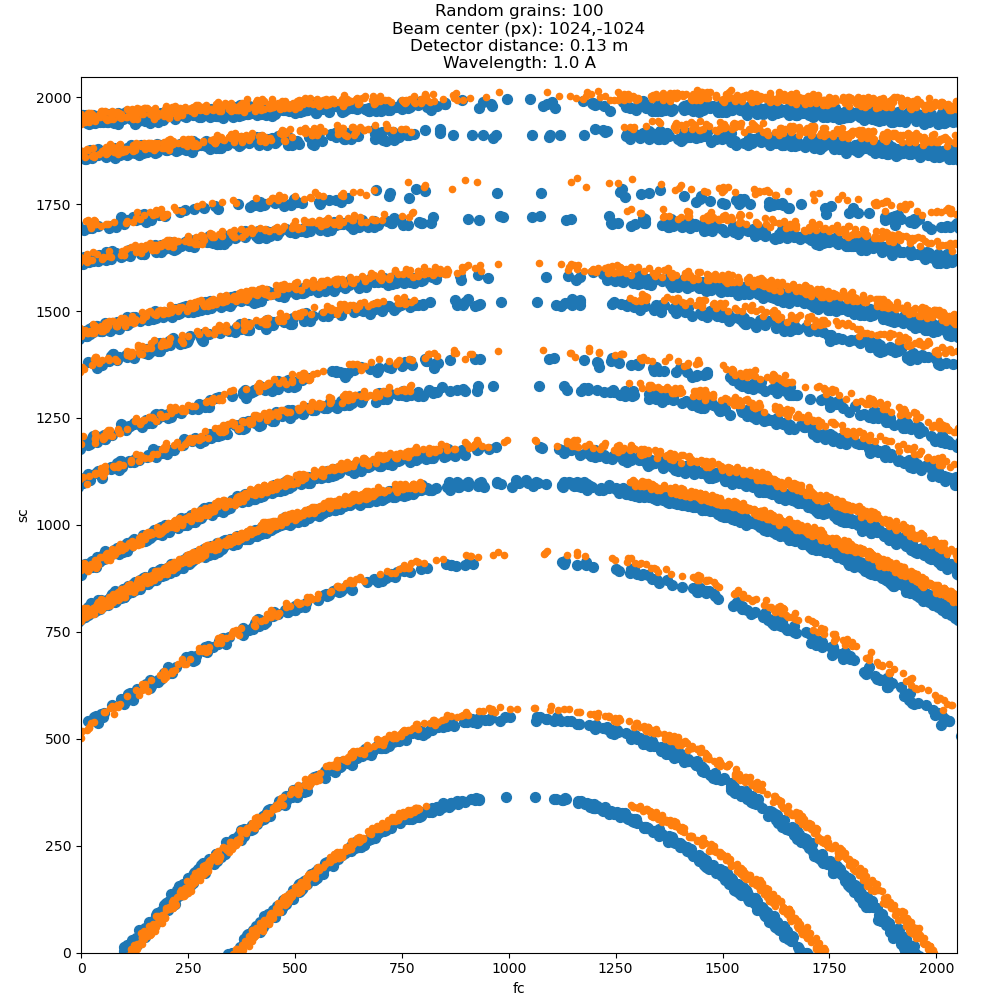

In [113]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc, sc, s=50)
ax.scatter(fc_r, sc_r, s=20)

ax.set_aspect(1)
ax.set(xlim=(0, 2048), ylim=(0, 2048))
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()

In [114]:
# compute g-vectors of all peaks with direct beam

In [115]:
sc_all = np.concatenate([sc[m], sc_r[m_r]])
fc_all = np.concatenate([fc[m], fc_r[m_r]])
omega_all = np.concatenate([omega[m], omega_r[m_r]])

In [116]:
gves_all_direct = mytrans.det_to_q_sample(sc_all, fc_all, omega_all, jnp.array([0., 0., 0]), k_in_norm,
                            pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                            det_trans, beam_cen_shift, x_distance_shift,)

In [117]:
gves_all_refl = mytrans.det_to_q_sample(sc_all, fc_all, omega_all, jnp.array([0., 0., 0]), k_in_refl,
                            pars.get('wedge'), pars.get('chi'), pars.get('wavelength'),
                            det_trans, beam_cen_shift, x_distance_shift,)

In [118]:
gves_all_direct.shape

(11459, 3)

In [119]:
gves_all_refl.shape

(11459, 3)

In [120]:
# make kdtree and keep gves that repeat

In [121]:
import scipy

kd_d = scipy.spatial.cKDTree( gves_all_direct )
kd_r = scipy.spatial.cKDTree( gves_all_refl )
# Find the pairs
coo = kd_d.sparse_distance_matrix( kd_r, 0.001, output_type = 'coo_matrix' )

In [122]:
# keep only those in the direct beam that have partners in the reflected beam less than the tolerance

In [123]:
mm = coo.row

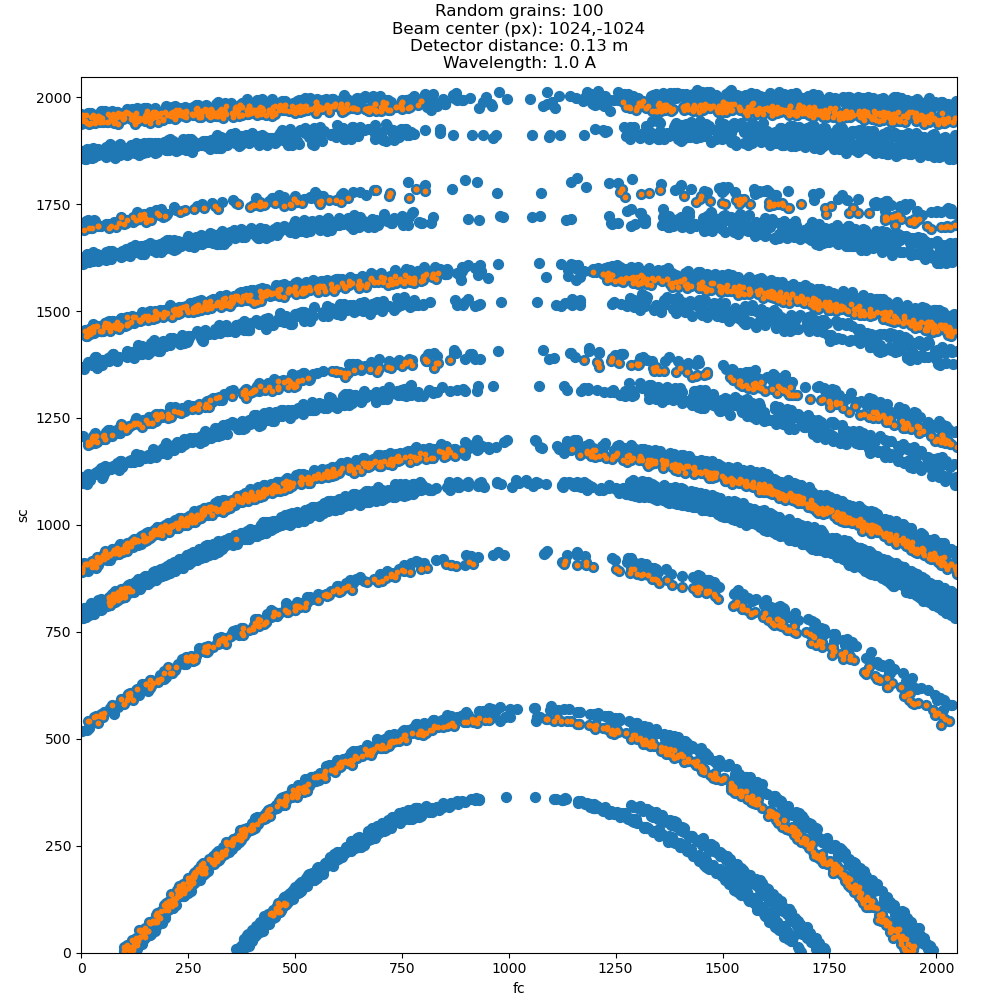

In [124]:
from matplotlib import pyplot as plt
%matplotlib ipympl

fig, ax = plt.subplots(constrained_layout=True, figsize=(10,10))
ax.scatter(fc_all, sc_all, s=50)
ax.scatter(fc_all[mm], sc_all[mm], s=10)

ax.set_aspect(1)
ax.set(xlim=(0, 2048), ylim=(0, 2048))
ax.set(xlabel='fc', ylabel='sc',
       title=f"""Random grains: {ng}
Beam center (px): {pars.get('y_center')},{pars.get('z_center')}
Detector distance: {pars.get('distance')/1e6:.4} m
Wavelength: {pars.get('wavelength'):.4} A""")
plt.show()

In [125]:
gves_merged = gves_all_direct[mm]
gves_merged.shape

(3430, 3)

In [126]:
# index merged

import ImageD11.indexing 
idx = ImageD11.indexing.indexer(unitcell=ref_ucell, gv=gves_merged)
idx.ds_tol = 0.02
idx.assigntorings()
idx.hkl_tol = 0.075
idx.score_all_pairs()

info: gv: [[-0.72556803 -0.71613258  0.85610373]
 [-0.72628674 -0.71528498  0.85561325]
 [-0.73486564 -0.70406649  0.86598987]
 ...
 [ 0.68732012  0.8023851   0.81926175]
 [ 0.71072657  0.71803799  0.87695979]
 [ 0.7107325   0.71866233  0.8804596 ]] (3430, 3) float64
info: Assign to rings, maximum d-spacing considered: 1.342823
info: Ring assignment array shape (3430,)
info: Ring     (  h,  k,  l) Mult  total indexed to_index  ubis  peaks_per_ubi   tth
info: Ring 6   ( -3, -2, -1)   48    728       0      728   N/A     N/A  -83.85
info: Ring 5   ( -2, -2, -2)    8    140       0      140   N/A     N/A  -76.43
info: Ring 4   ( -3,  0, -1)   24    563       0      563   N/A     N/A  -68.76
info: Ring 3   (  0, -2, -2)   12    256       0      256   N/A     N/A  -60.67
info: Ring 2   ( -1, -2, -1)   24    750       0      750   N/A     N/A  -51.88
info: Ring 1   (  0,  0, -2)    6    269       0      269   N/A     N/A  -41.85
info: Ring 0   ( -1,  0, -1)   12    653       0      653   N/A

In [127]:
# # index normal

# import ImageD11.indexing
# idx = ImageD11.indexing.indexer(unitcell=ref_ucell, gv=gves_n)
# idx.ds_tol = 0.02
# idx.assigntorings()
# idx.hkl_tol = 0.050
# idx.score_all_pairs()

In [ ]:
# # index just reflected

# idx_r = ImageD11.indexing.indexer(unitcell=ref_ucell, gv=gves_r)
# idx_r.ds_tol = 0.02
# idx_r.assigntorings()
# idx_r.hkl_tol = 0.050
# idx_r.score_all_pairs()

In [ ]:
# import ImageD11.columnfile
# cf_obs = ImageD11.columnfile.columnfile(new=True)
# cf_obs.nrows = fc_r[m_r].shape[0]
# cf_obs.addcolumn(fc_r[m_r], 'fc')
# cf_obs.addcolumn(sc_r[m_r], 'sc')
# cf_obs.addcolumn(omega_r[m_r], 'omega')
# cf_obs.parameters = pars

In [128]:
import ImageD11.columnfile
cf_obs = ImageD11.columnfile.columnfile(new=True)
cf_obs.nrows = fc_all[mm].shape[0]
cf_obs.addcolumn(fc_all[mm], 'fc')
cf_obs.addcolumn(sc_all[mm], 'sc')
cf_obs.addcolumn(omega_all[mm], 'omega')
cf_obs.parameters = pars

In [129]:
cf_obs.updateGeometry()

In [130]:
idx.saveubis('grains.ubi')

In [131]:
cf_obs.parameters.get_parameters().update(idx.unitcell.to_par_dict())
cf_obs.parameters.saveparameters('pars.par')

In [132]:
cf_obs.writefile('peaks.flt')

In [133]:
!makemap.py -u grains.ubi -U grains.map -f peaks.flt -p pars.par -t 0.05 --no_sort

/cvmfs/hpc.esrf.fr/software/packages/linux/x86_64/jupyter-slurm/2025.04.2/envs/jupyter-slurm/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Using 0.5 degree slop
got pars
got filtered
got ubis
generating
resetting labels
Refining posi too
Refining positions too
Assigning labels with XLYLZL
Start first grain loop 0.013462066650390625
0.10210943222045898 First loop
End first grain loop 0.102630615234375
(3430,) -2.0 -2.0
(3430,) -1 97
Start second grain loop 0.0001842975616455078
Grain 0 Scan peaks.flt npks= 32
Grain 1 Scan peaks.flt npks= 40
Grain 2 Scan peaks.flt npks= 38
Grain 3 Scan peaks.flt npks= 25
Grain 4 Scan peaks.flt npks= 43
Grain 5 Scan peaks.flt npks= 32
Grain 6 Scan peaks.flt npks= 28
Grain 7 Scan peaks.flt npks= 37
Grain 8 Scan peaks.flt npks= 0
Grain 9 Scan peaks.flt npks= 39
Grain 10 Scan peaks.flt npks= 50
Grain 11 Scan peaks.flt npks= 37
Grain 12 Scan peaks.flt npks= 13
Grain 13 Scan peaks.flt npks= 32
Grain 14 Scan peaks.flt npks= 28
Grain 15 Scan peaks.flt npks= 56
Grain 16 Scan peaks.flt npks= 29
Grain 17 Scan peaks.flt npks= 2
Grain 18 Scan peaks.flt npks= 36
Grain 19 Scan peaks.flt npks= 29
Grain 20 

In [134]:
!makemap.py -u grains.map -U grains.map -f peaks.flt -p pars.par -t 0.025 --no_sort

Using 0.5 degree slop
got pars
got filtered
got ubis
generating
resetting labels
Refining posi too
Refining positions too
Assigning labels with XLYLZL
Start first grain loop 0.01317596435546875
0.04469776153564453 First loop
End first grain loop 0.04481363296508789
(3430,) -2.0 -2.0
(3430,) -1 97
Start second grain loop 0.000171661376953125
Grain 0 Scan peaks.flt npks= 32
Grain 1 Scan peaks.flt npks= 36
Grain 2 Scan peaks.flt npks= 34
Grain 3 Scan peaks.flt npks= 26
Grain 4 Scan peaks.flt npks= 35
Grain 5 Scan peaks.flt npks= 32
Grain 6 Scan peaks.flt npks= 21
Grain 7 Scan peaks.flt npks= 34
Grain 8 Scan peaks.flt npks= 0
Grain 9 Scan peaks.flt npks= 33
Grain 10 Scan peaks.flt npks= 48
Grain 11 Scan peaks.flt npks= 35
Grain 12 Scan peaks.flt npks= 6
Grain 13 Scan peaks.flt npks= 28
Grain 14 Scan peaks.flt npks= 26
Grain 15 Scan peaks.flt npks= 56
Grain 16 Scan peaks.flt npks= 29
Grain 17 Scan peaks.flt npks= 3
Grain 18 Scan peaks.flt npks= 32
Grain 19 Scan peaks.flt npks= 28
Grain 20 S

In [135]:
!makemap.py -u grains.map -U grains.map -f peaks.flt -p pars.par -t 0.01 --no_sort

Using 0.5 degree slop
got pars
got filtered
got ubis
generating
resetting labels
Refining posi too
Refining positions too
Assigning labels with XLYLZL
Start first grain loop 0.019243240356445312
0.17405962944030762 First loop
End first grain loop 0.17421770095825195
(3430,) -2.0 -2.0
(3430,) -1 97
Start second grain loop 0.00016760826110839844
Grain 0 Scan peaks.flt npks= 32
Grain 1 Scan peaks.flt npks= 34
Grain 2 Scan peaks.flt npks= 34
Grain 3 Scan peaks.flt npks= 24
Grain 4 Scan peaks.flt npks= 35
Grain 5 Scan peaks.flt npks= 30
Grain 6 Scan peaks.flt npks= 24
Grain 7 Scan peaks.flt npks= 26
Grain 8 Scan peaks.flt npks= 0
Grain 9 Scan peaks.flt npks= 33
Grain 10 Scan peaks.flt npks= 46
Grain 11 Scan peaks.flt npks= 35
Grain 12 Scan peaks.flt npks= 3
Grain 13 Scan peaks.flt npks= 20
Grain 14 Scan peaks.flt npks= 26
Grain 15 Scan peaks.flt npks= 56
Grain 16 Scan peaks.flt npks= 29
Grain 17 Scan peaks.flt npks= 1
Grain 18 Scan peaks.flt npks= 30
Grain 19 Scan peaks.flt npks= 28
Grain 2

In [136]:
import ImageD11.grain

In [137]:
grains = ImageD11.grain.read_grain_file('grains.map')
for g in grains:
    g.ref_unitcell = ref_ucell

In [138]:
grains = [g for g in grains if 'no peaks' not in g.intensity_info]

In [139]:
import ImageD11.nbGui.nb_utils as utils

In [143]:
dir(g[0])

TypeError: 'grain' object is not subscriptable

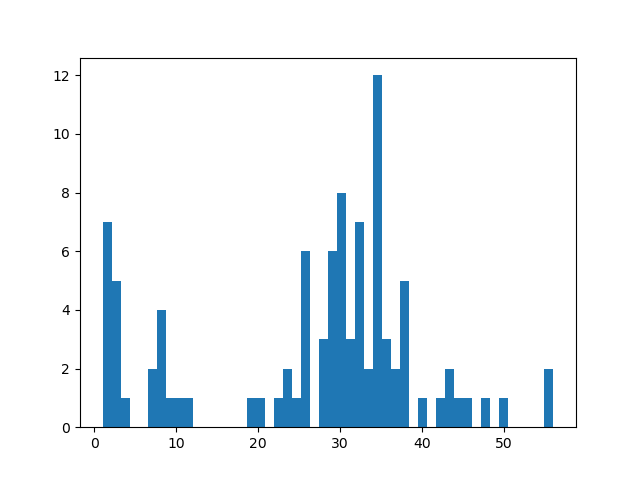

In [144]:
fig, ax = plt.subplots()
ax.hist([int(g.npks) for g in grains], bins=50)
plt.show()

In [145]:
grains_nice = [g for g in grains if int(g.npks) > 15]

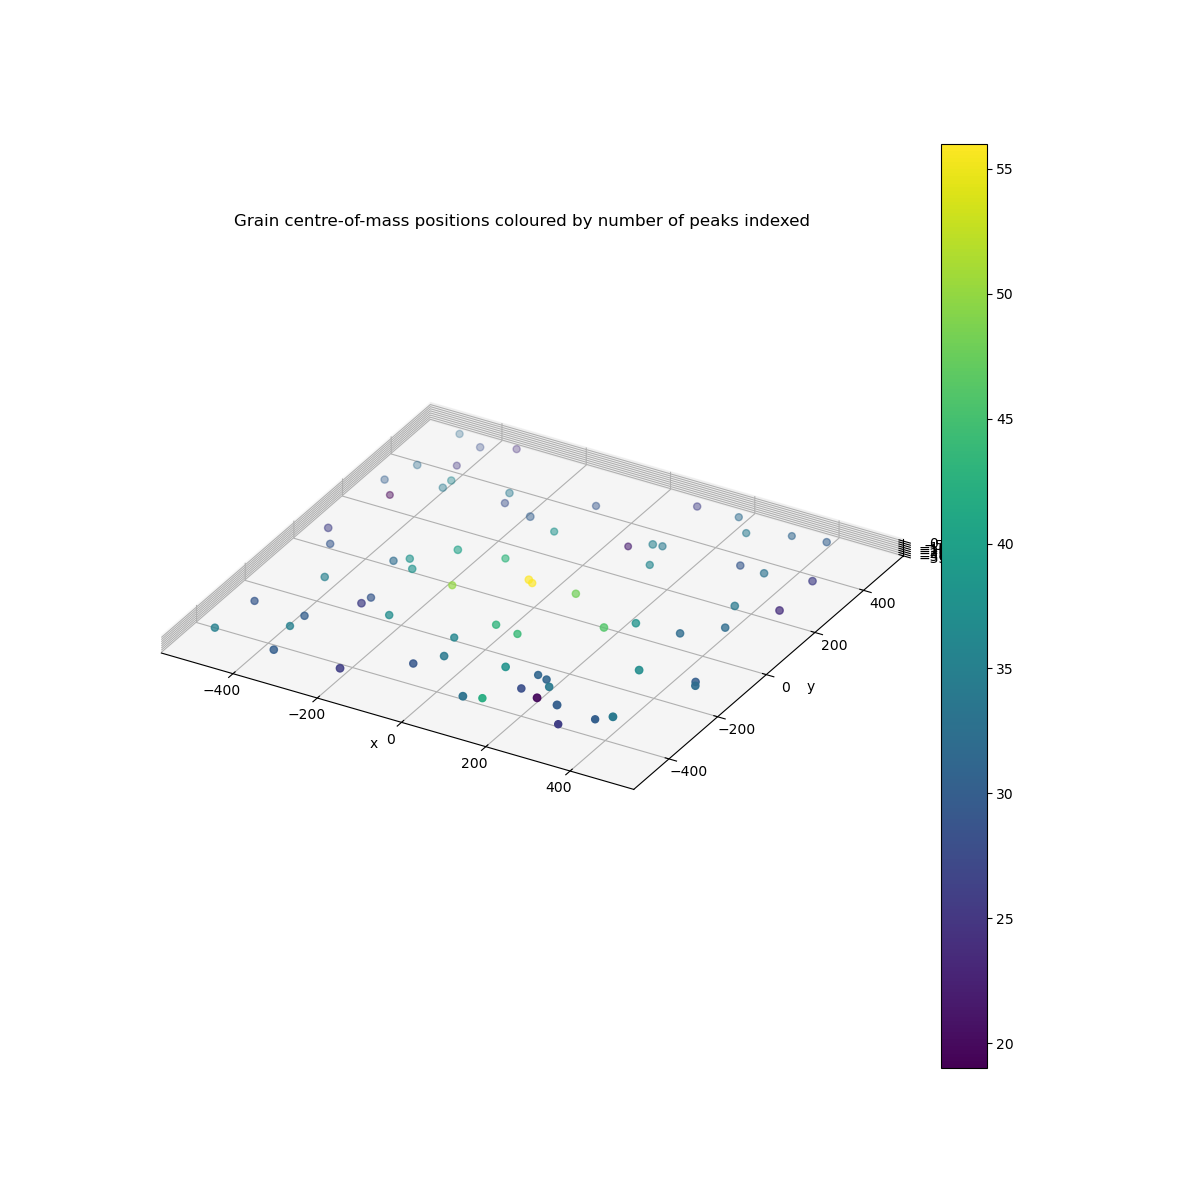

In [146]:
utils.plot_grain_positions(grains_nice, size_scaling=50)